In [77]:
import xarray as xr
import datetime as dt
import numpy as np
import glob
from barpa_read import drop_duplicates
import pandas as pd
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [78]:
def preprocess(ds):
    year = ds["time"].units.split(" ")[-1]
    ds = ds.assign_coords(time=[dt.datetime(int(year),1,1,0) + dt.timedelta(hours=int(i)) for i in np.arange(len(ds.time.values))])
    return ds


In [79]:
#Load the WWLLN data, and resample to daily intervals by summing strokes over the hourly intervals
start_year=2005
end_year=2015
wwlln = xr.open_mfdataset("/g/data/eg3/ab4502/ExtremeWind/ad_data/lightning_1hr/*.nc", decode_times=False, preprocess=preprocess)
wwlln = wwlln.resample({"time":"1D"}).sum()
wwlln = wwlln.sel({"time":(np.in1d(wwlln["time.year"], np.arange(start_year,end_year+1))) & \
                        (np.in1d(wwlln["time.month"],[12,1,2])) & \
                  (pd.to_datetime(wwlln.time.values) <= dt.datetime(2015,3,1)),
                 "lon":slice(112,156),"lat":slice(-44.5,-10)})



/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [4]:
from era5_spatial_cluster import *
y=2015
f = load_era5(str(y))
cluster_mod, cluster_input = load_cluster()
s06, qmean01, lr13, Umean06 = transform_era5(f, cluster_mod, cluster_input)
era5_cluster = era5_clustering(s06, qmean01, lr13, Umean06, f, cluster_mod)

In [50]:
cluster1 = (era5_cluster.cluster == 0).resample(time="1D").max("time").sel(time=wwlln.time,lat=wwlln.lat,lon=wwlln.lon)
cluster2 = (era5_cluster.cluster == 1).resample(time="1D").max("time").sel(time=wwlln.time,lat=wwlln.lat,lon=wwlln.lon)
cluster3 = (era5_cluster.cluster == 2).resample(time="1D").max("time").sel(time=wwlln.time,lat=wwlln.lat,lon=wwlln.lon)

In [61]:
cluster1_lightning = xr.where(cluster1,(wwlln.Lightning_observed>=1)*1,np.nan)
cluster2_lightning = xr.where(cluster2,(wwlln.Lightning_observed>=1)*1,np.nan)
cluster3_lightning = xr.where(cluster3,(wwlln.Lightning_observed>=1)*1,np.nan)

/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


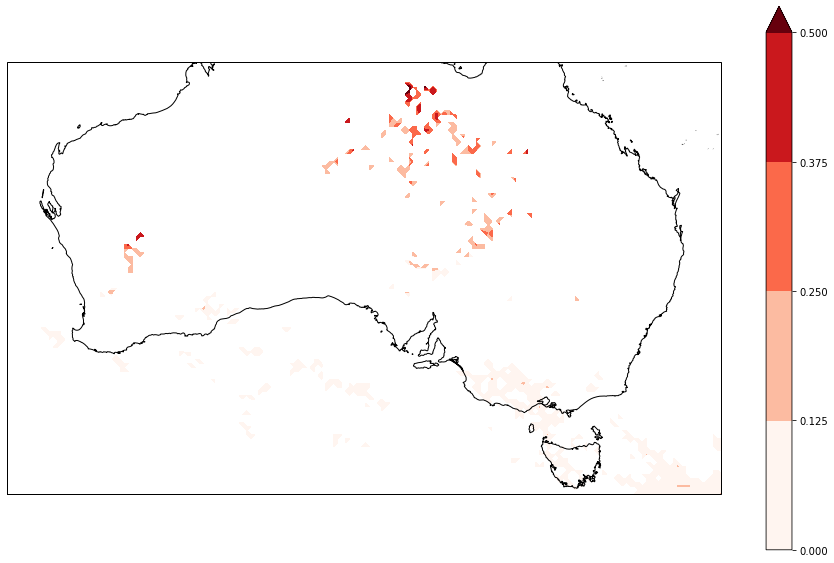

In [83]:
plt.figure(figsize=[16,10])
ax=plt.axes(projection=ccrs.PlateCarree())
xr.plot.contourf(
    xr.where(cluster1_lightning.sum("time")>1,cluster1_lightning.mean("time"),np.nan),ax=ax,levels=np.linspace(0,0.5,5),cmap=plt.get_cmap("Reds"))
ax.coastlines(resolution="10m")

/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


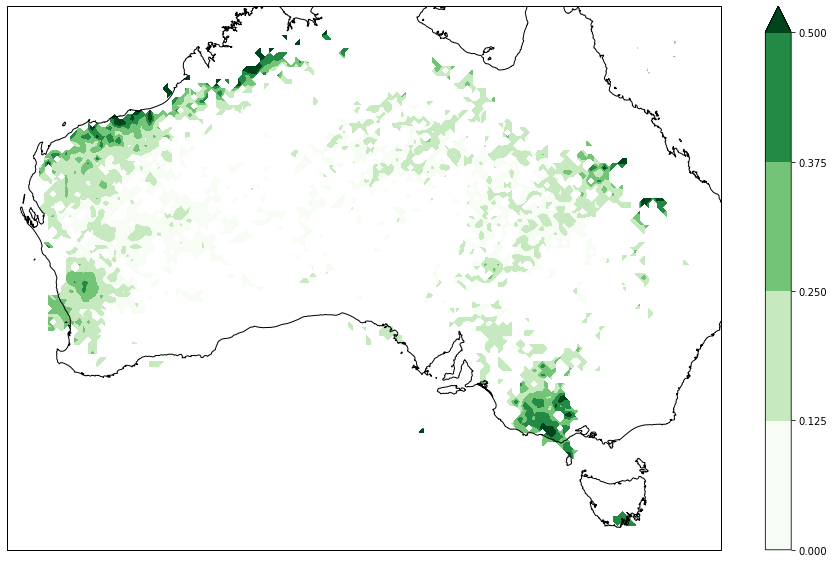

In [85]:
plt.figure(figsize=[16,10])
ax=plt.axes(projection=ccrs.PlateCarree())
xr.plot.contourf(
    xr.where(cluster2_lightning.sum("time")>1,cluster2_lightning.mean("time"),np.nan),ax=ax,levels=np.linspace(0,0.5,5),cmap=plt.get_cmap("Greens"))
ax.coastlines(resolution="10m")

/g/data/eg3/ab4502/miniconda3/envs/wrfpython3.6/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


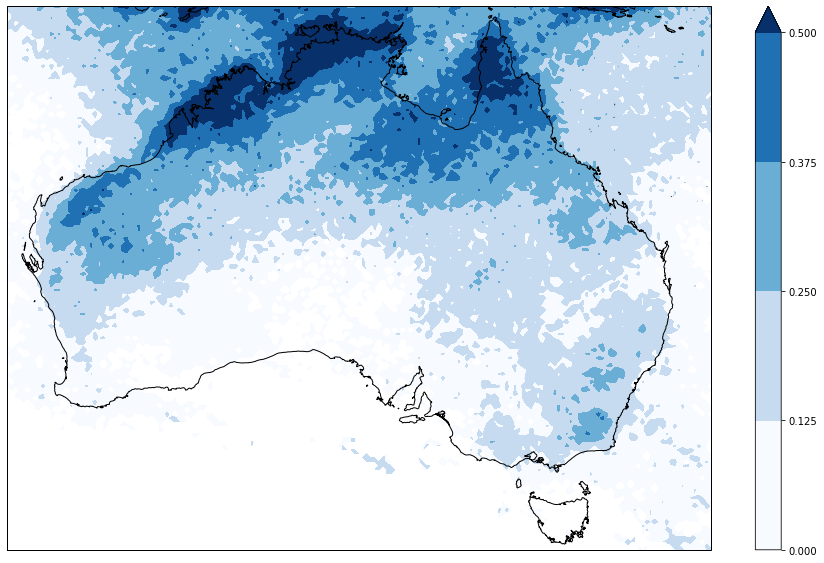

In [86]:
plt.figure(figsize=[16,10])
ax=plt.axes(projection=ccrs.PlateCarree())
xr.plot.contourf(
    xr.where(cluster3_lightning.sum("time")>1,cluster3_lightning.mean("time"),np.nan),ax=ax,levels=np.linspace(0,0.5,5),cmap=plt.get_cmap("Blues"))
ax.coastlines(resolution="10m")

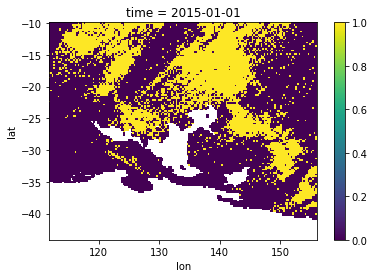

In [89]:
cluster3_lightning.isel(time=0).plot()